In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Example 2 - Clustering and DE-analysis
#
# This notebook illustrates some
# of the downstream analyses
# that can be performed on Visium data.
# 
# We'll focus on the isocortex/neocortex
# first cluster the data and then look
# at what genes are characteristic of
# each of these clusters.

In [3]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import helpers
import stx as stx
import utils as ut

In [4]:
# Load Data

pths = dict(sample_2 = dict(cnt = "../data/Allen-2/Allen-2-count-matrix.tsv.gz",
                            img = "../data/Allen-2/tissue_hires_image.png",
                            scf = "../data/Allen-2/scalefactors_json.json",
                            mta = "../data/Allen-2/allen-2-meta.tsv",
                            ),
            sample_1 = dict(cnt = "../data/Allen-1/Allen-1-count-matrix.tsv.gz",
                            img = "../data/Allen-1/tissue_hires_image.png",
                            scf = "../data/Allen-1/scalefactors_json.json",
                            mta = "../data/Allen-1/allen-1-meta.tsv",
                            ),
           )

data_1 = stx.STdata(**pths["sample_1"])
data_2 = stx.STdata(**pths["sample_2"])
# bundle data for ease of analysis
bundle = stx.DataBundle([data_1,data_2])

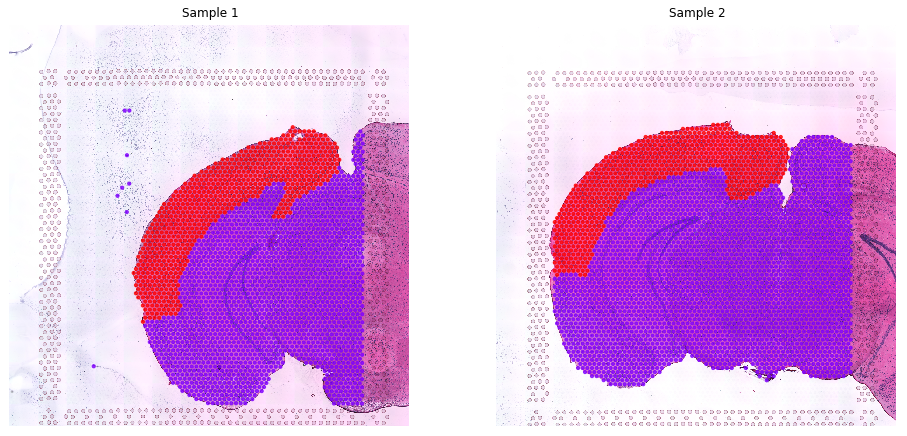

In [5]:
# We can select only a subset of our spots,
# such as those belonging to the isocortex and
# provide this as meta data to our analysis.

# We'll use these (rather sloppy)
# annotations of the isocortex

data_1.set_foi('region')
data_2.set_foi('region')

fig,axs = plt.subplots(1,2,figsize = (16,8))
fig,axs = bundle.plot(fig = fig,
            axs = axs,
            cmap = plt.cm.rainbow,
            marker_size = 10,
            alpha = 0.8)
axs[0].set_title("Sample 1")
axs[1].set_title("Sample 2")
plt.show()

In [6]:
# Before moving on to the actual analysis
# we will do some filtering w.r.t. quality
#
# Those genes present in less than 10 different spots
# and/or have less than 300 transcripts will be removed

bundle.filter_genes(min_obs = 10,
                    min_tot = 300)

In [7]:
# We will continue to work with only the 
# neocortex spots shown above
bundle.set_active('region',1)

In [8]:
# First, the spots are clustered 
# based on their expression profiles
#

%matplotlib inline

# For an initial quick analysis we could also
# cluster the expression data. 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import umap

np.random.seed(1337)

# specify number of clusters (arbitrarily choosen)
n_clusters = 9
# specify dimension of subspace spanned by IC's
n_dims = 40


dimred = FastICA(n_components = n_dims)
km = KMeans(n_clusters = n_clusters)

# normalize the data
ncnt = stx.normalize_cnt(bundle.cnt.values)
# reducre dimensionality
ncnt = dimred.fit_transform(ncnt)
# Cluster the data
cidx = km.fit_predict(ncnt)
# Project into 2 dim. space for visualization
umap_crd = umap.UMAP().fit_transform(ncnt)

In [9]:
# Add the cluster indices to
# the meta data
bundle.add_meta('cluster',cidx)

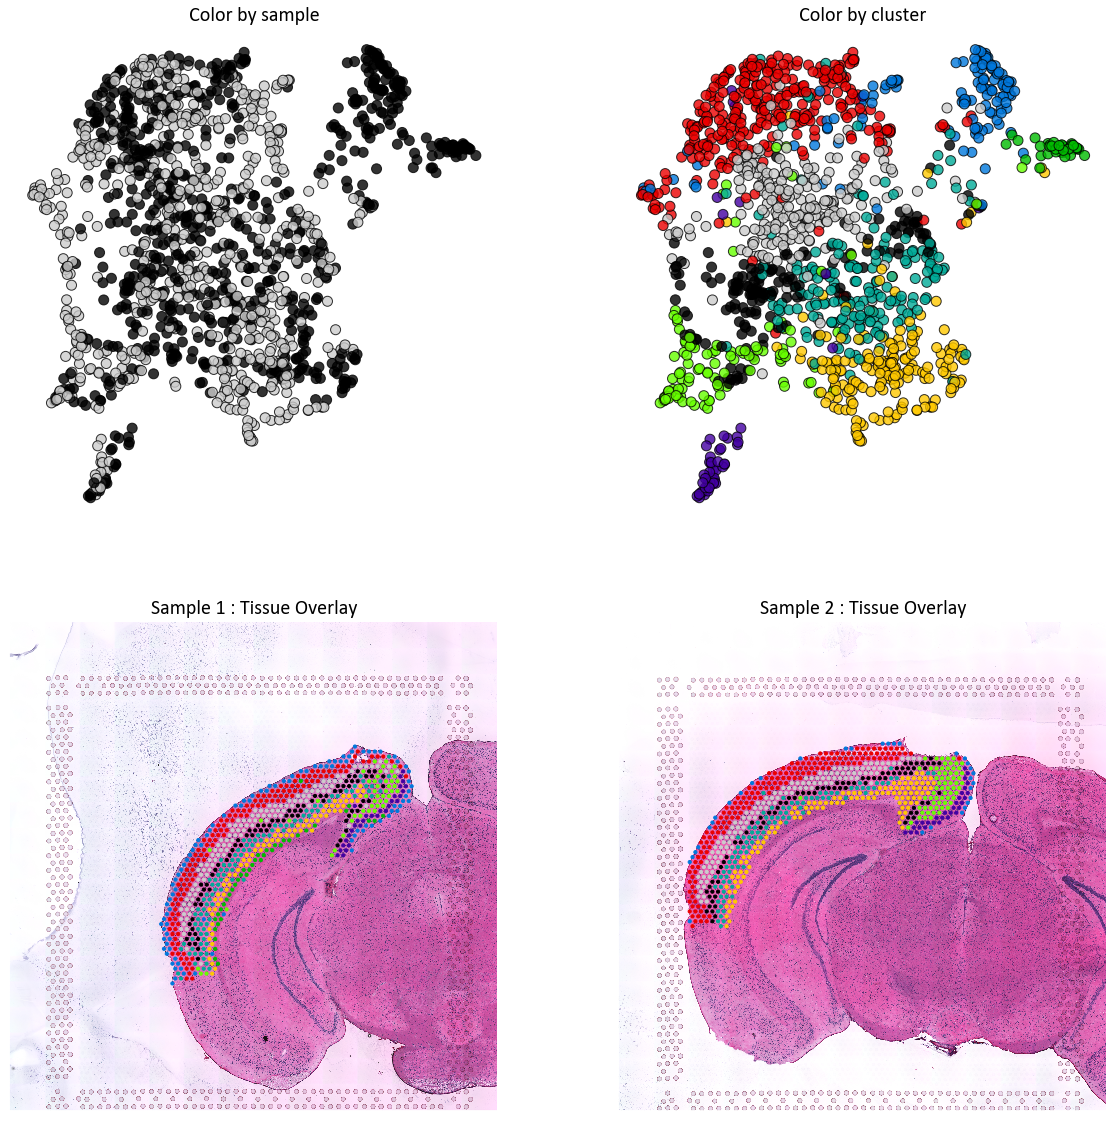

In [10]:
# Visualize the obtained clustering results

#


cmap = plt.cm.nipy_spectral
n_rows = int(1 + np.ceil(bundle.n_sets / 2))
fontdict = dict(fontsize = 20, fontfamily = 'Calibri')

fig, ax = plt.subplots(2,
                       n_rows,
                       figsize = (20,10*n_rows))
ax = ax.flatten()

srt = np.random.permutation(cidx.shape[0])
vals = np.zeros(cidx.shape[0])

for ii in np.unique(bundle.mta['set'].values):
    vals[bundle.mta['set'].values == ii] = ii
# UMAP projection with coloring (QC)
for k,color in enumerate([vals,cidx]):
    sct = ax[k].scatter(umap_crd[srt,0],
                        umap_crd[srt,1],
                        c = color[srt],
                        cmap = cmap,
                        edgecolor = 'black',
                        alpha = 0.8,
                        s= 100,
                        )
    

ax[0].set_title("Color by sample",**fontdict)
ax[1].set_title("Color by cluster",**fontdict)

# Tissue overlay (only using selected spots



for s,ii in enumerate(np.unique(bundle.mta['set'].values)):
    sub_sel = bundle.active_set[s]
    
    ax[2+s].imshow(bundle.sets[s].img)
    ax[2+s].scatter(bundle(s).crd[sub_sel,1] \
                    * bundle(s).sf,
                    bundle(s).crd[sub_sel,0] \
                    * bundle(s).sf,
                    c = cidx[bundle.mta['set'] == ii],
                    cmap = cmap,
                    s = 10)

    ax[2+s].set_title("Sample " + \
                      str(s+1) + \
                      " : Tissue Overlay",
                     **fontdict)

for ii in range(4):
    ut.clean_spines(ax[ii])
    ut.clean_ticks(ax[ii])
    ax[ii].set_aspect('equal')

In [11]:
# There's quite some intermixing of spots from the
# different samples - indicating we do not
# suffer from major batch effects.
# 
# Overlaying the clusters ontop of the tissue
# there's also consistency between the two
# samples - with the same arrangement of multiple
# layers.

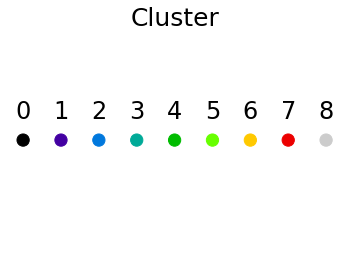

In [12]:
# Creating a "legend" for referene

_, ax = ut.cmap_legend(n_clusters,cmap)
ax.set_title("Cluster", fontsize = 25)
plt.show()

In [13]:
# We will aslo do a simple DE analysis, extracting
# genes which are specific to each cluster

# In short, we assume the counts are NB distributed
# and fit a full (cluster identity included) respectively
# a reduced model (cluster identity excluded) model
# and then conduct LR test to see for where the full model is 
# signigicantly better
#
# MHT correction is done using FDR-BH


import dge

# set number of top DE genes to extract
# min(n_top,n_signigicant) genes will be extracted
n_top = 10
# set significance level
alpha = 0.01

top_dge = {}
# iteate over all clusters
for cluster in np.unique(bundle.mta['cluster'].values):
    # --- construct design matrix --- #
    full_design = np.zeros((bundle.cnt.shape[0],
                            3 + bundle.n_sets))
    
    #intercept
    full_design[:,0] = 1 
    # library size
    full_design[:,1] = np.log(bundle.cnt.values.sum(axis = 1) + 1) 
    
    # batch/section/sample
    for k,s in enumerate(np.unique(bundle.mta['set'].values)):
        full_design[bundle.mta['set'].values == s,2+k] = 1

    # cluster
    full_design[bundle.mta['cluster'].values == cluster,-1] = 1
    
    # --- find DE genes --- #
    dge_res = dge.dge_analysis(bundle.cnt,
                           full_design,
                           )
    # select significant and up-regulated genes
    dge_res = dge_res.iloc[dge_res['adj_pval'].values < alpha,:]
    dge_res = dge_res.iloc[dge_res['l2fc'].values > 0,:]
    # number of genes to add to top
    n_pick = np.min((dge_res.shape[0],n_top))
    ordr = np.argsort(dge_res['l2fc'].values)[::-1][0:n_pick]
    # add genes to "top-list"
    top_dge.update({cluster:dge_res.iloc[ordr]})

In [18]:
# Next we inspect how the actual expression value
# of the identified DE genes look within our section
# for a certain cluster and section

def visualize_dge(sel_cluster,sel_section):
    """
    Blasphemy of a function to visualize
    the genes identified in the DE analysis.
    
    """
    d2sel = (bundle(sel_section).mta['region'].values == 1).flatten()
    b2sel = (bundle.mta['cluster'].values == sel_cluster).flatten()
    b2sel = b2sel[(bundle.mta['set'].values == sel_section)]


    cval = np.ones(b2sel.shape) * -1

    cval[b2sel] = sel_cluster

    fig,ax = plt.subplots(2,
                          5,
                          figsize=(20,10),
                         )
    ax = ax.flatten()

    ax[0].scatter(bundle(sel_section).crd[d2sel,1],
                  bundle(sel_section).crd[d2sel,0],
                  c = cval,
                  cmap = plt.cm.jet),
    ax[0].set_title("cluster " + \
                    str(sel_cluster) + \
                    " sample " +\
                    str(sel_section +1 ))


    for ii in range(1,n_top):
        if ii >= top_dge[sel_cluster].shape[0]:
            continue

        gene = top_dge[sel_cluster].index[ii-1]
        
        expr_val = np.log2(2 + bundle(sel_section).cnt.loc[:,gene].values[d2sel])

        ax[ii].scatter(bundle(sel_section).crd[d2sel,1],
                bundle(sel_section).crd[d2sel,0],
                c = expr_val,
                s = 5,
                cmap = plt.cm.YlGnBu,
                linewidth  = 1,
               )

        ax[ii].set_title(gene)

    for ii in range(10):
        ax[ii].invert_yaxis()
        ut.clean_spines(ax[ii])
        ut.clean_ticks(ax[ii])
        ax[ii].set_aspect("equal")

    plt.show()

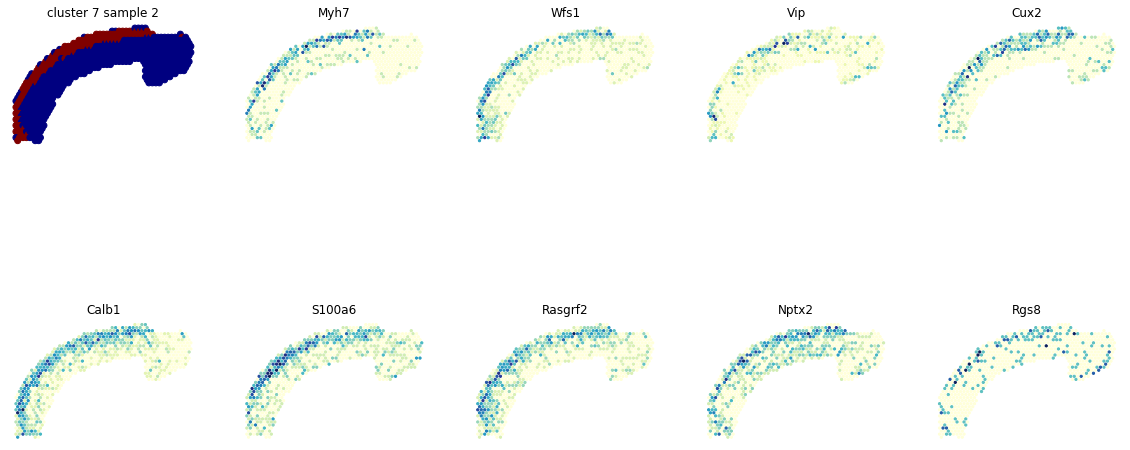

In [19]:
# Looking at genes associated with cluster 7 in sample 2
# gives the following results

visualize_dge(7,1)


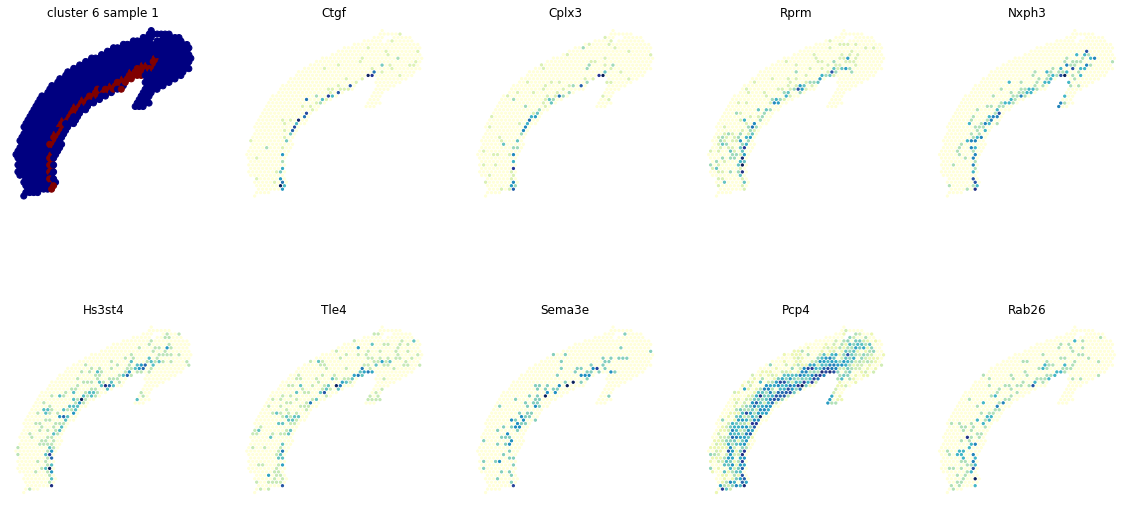

In [20]:
# To further examplify, we can for example look at
# genes associated with cluster 6 in sample 1

visualize_dge(6,0)